Imports

In [10]:
import sys
import os
sys.path.append(os.path.dirname(os.path.abspath('.')))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.preprocessing import Preprocessor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Pour ne pas afficher de warnings inutiles
import warnings
warnings.filterwarnings("ignore")

Chargement des données

In [16]:
champs_elysees_df = pd.read_csv('data/traffic/champs_elysees.csv', sep=";")
weather_df = pd.read_csv('data/weather/weather_paris.csv')
holidays_df = pd.read_csv('data/events/french_holidays.csv', sep=";")
football_matches_df = pd.read_csv('data/events/football_matches_2024_2025.csv')

Processing

In [17]:
preprocessor = Preprocessor(df=champs_elysees_df)

df_processed = preprocessor.fit_transform(
    holidays_df=holidays_df,
    weather_df=weather_df,
    sports_df=football_matches_df
)

print("Preprocessed Data :", df_processed.shape)
display(df_processed.sample(5))

# On s'assure que l'index est bien temporel (si ce n'est pas déjà le cas)
if not np.issubdtype(df_processed.index.dtype, np.datetime64):
    # adapter le nom de colonne si besoin
    if "Date et heure de comptage" in df_processed.columns:
        df_processed["Date et heure de comptage"] = pd.to_datetime(
            df_processed["Date et heure de comptage"]
        )
        df_processed = df_processed.set_index("Date et heure de comptage")
    else:
        # si Preprocessor crée déjà un index temporel, on ne fait rien
        pass

df_processed = df_processed.sort_index()

Preprocessed Data : (8627, 43)


,Identifiant arc,Libelle,Débit horaire,Taux d'occupation,Etat trafic,Identifiant noeud amont,Libelle noeud amont,Identifiant noeud aval,Libelle noeud aval,Etat arc,...,relative_humidity_2m (%),precipitation (mm),wind_speed_10m (km/h),weather_code (wmo code),surface_pressure (hPa),cloud_cover (%),apparent_temperature (°C),rain (mm),sport_event_name,is_sport_event
Date et heure de comptage,,,,,,,,,,,,,,,,,,,,,
2025-02-25 23:00:00,4264,AV_Champs_Elysees,646.0,8.78500,Fluide,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Ouvert,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2024-10-28 02:00:00,4264,AV_Champs_Elysees,367.0,4.96667,Fluide,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2025-10-30 09:00:00,4264,AV_Champs_Elysees,1082.0,19.59222,Pré-saturé,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Ouvert,...,77.0,0.0,6.5,3.0,1006.6,100.0,8.9,0.0,NaN,False
2025-02-27 22:00:00,4264,AV_Champs_Elysees,738.0,10.94167,Fluide,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Ouvert,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2025-03-15 15:00:00,4264,AV_Champs_Elysees,939.0,19.04000,Pré-saturé,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Ouvert,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


Construction X/Y

In [18]:
target_cols = ["Débit horaire", "Taux d'occupation"]

# On enlève les colonnes cibles + colonnes non numériques / identifiants
cols_to_drop = [
    "Identifiant arc", "Libelle",
    "Identifiant noeud amont", "Libelle noeud amont",
    "Identifiant noeud aval", "Libelle noeud aval",
    "Etat arc", "Etat trafic",
    "sport_event_name",   # texte
]

# On ne droppe que ce qui existe réellement
cols_to_drop = [c for c in cols_to_drop if c in df_processed.columns]

df_model = df_processed.drop(columns=cols_to_drop, errors="ignore")

# Sélection des features numériques uniquement (Random Forest ne gère pas le texte brut)
X = df_model.drop(columns=target_cols)
X = X.select_dtypes(include=[np.number]).copy()

y = df_model[target_cols].copy()

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (8627, 22)
y shape: (8627, 2)


Split temporel train/test

In [19]:
train_ratio = 0.8
n_samples = len(X)
train_size = int(n_samples * train_ratio)

X_train = X.iloc[:train_size]
X_test = X.iloc[train_size:]

y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]

print(f"Train size: {X_train.shape[0]} samples")
print(f"Test size : {X_test.shape[0]} samples")

Train size: 6901 samples
Test size : 1726 samples


Entrainement

In [20]:
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    n_jobs=-1,
    random_state=42
)

rf_model.fit(X_train, y_train)

,n_estimators,300
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Prédiction et évaluation

In [21]:
y_pred = rf_model.predict(X_test)  # shape (n_samples, 2)
y_pred = pd.DataFrame(
    y_pred,
    index=y_test.index,
    columns=target_cols
)

def compute_metrics(y_true, y_pred, col_name):
    rmse = np.sqrt(mean_squared_error(y_true[col_name], y_pred[col_name]))
    mean_val = y_true[col_name].mean()
    rel_error = rmse / mean_val * 100 if mean_val != 0 else np.nan
    return rmse, mean_val, rel_error

for col in target_cols:
    rmse, mean_val, rel_err = compute_metrics(y_test, y_pred, col)
    print(
        f"{col} : RMSE = {rmse:.2f}, "
        f"Mean = {mean_val:.2f}, "
        f"Relative error = {rel_err:.2f}%"
    )

Débit horaire : RMSE = 182.56, Mean = 739.04, Relative error = 24.70%
Taux d'occupation : RMSE = 7.06, Mean = 16.53, Relative error = 42.71%


Visualisation

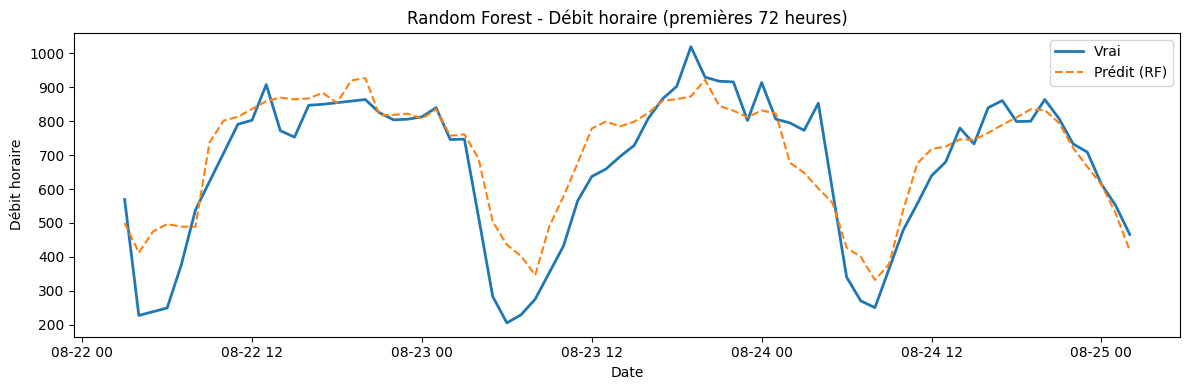

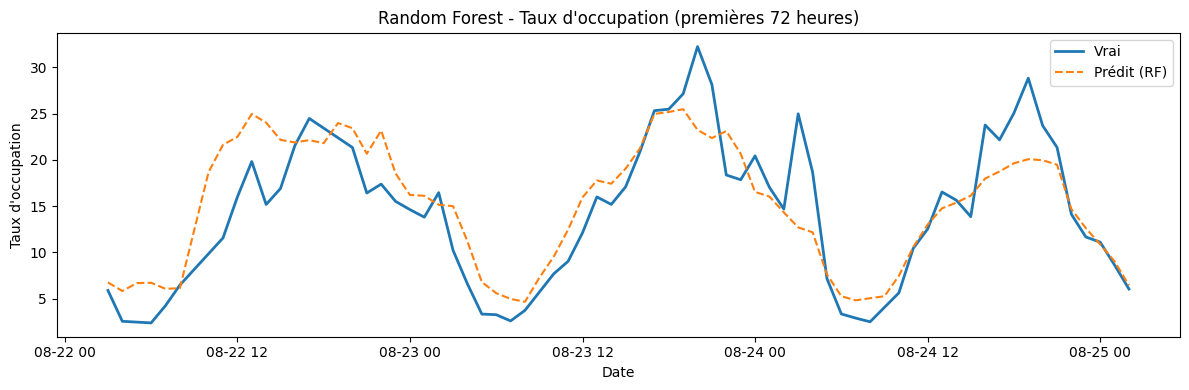

In [22]:
def plot_rf_predictions(y_test, y_pred, col_name, n_plot=72):
    """
    Affiche les n_plot premières heures de test pour une variable cible.
    """
    plt.figure(figsize=(12, 4))
    subset_true = y_test[col_name].iloc[:n_plot]
    subset_pred = y_pred[col_name].iloc[:n_plot]

    plt.plot(subset_true.index, subset_true.values, label="Vrai", linewidth=2)
    plt.plot(subset_pred.index, subset_pred.values, label="Prédit (RF)", linestyle="--")

    plt.title(f"Random Forest - {col_name} (premières {n_plot} heures)")
    plt.xlabel("Date")
    plt.ylabel(col_name)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Exemple : visualiser les 72 premières heures de la série de test
plot_rf_predictions(y_test, y_pred, "Débit horaire", n_plot=72)
plot_rf_predictions(y_test, y_pred, "Taux d'occupation", n_plot=72)